### Digit Recognizer Project

In [181]:
# Importing Libaries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from sklearn import preprocessing

In [182]:
# Impoting Train Data
pwd = os.getcwd()
traindf = pd.read_csv(pwd + "/train.csv")

In [183]:
# Exploring Data
print(traindf.shape)
traindf.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [184]:
# Checking of NaN Data
print("Number of NaN values:")
traindf.isna().sum().sort_values(ascending=False).head()

Number of NaN values:


label       0
pixel515    0
pixel517    0
pixel518    0
pixel519    0
dtype: int64

In [185]:
# Check Duplicates
print("Number of duplicated rows: {}".format(len(traindf[traindf.duplicated(keep=False)])))

Number of duplicated rows: 0


Preview of First 256 digit figures


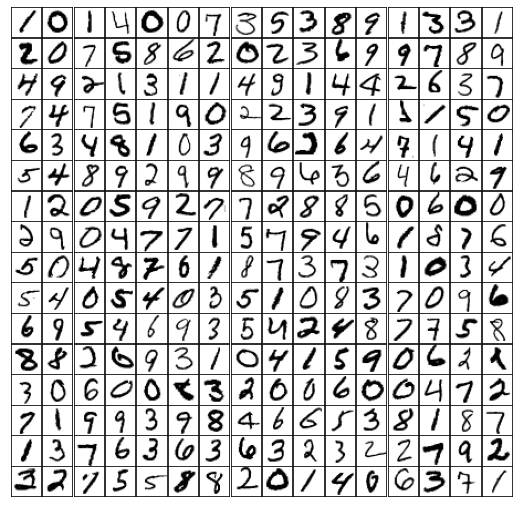

In [186]:
# Preview of the figures
print("Preview of First 256 digit figures")
traindfpix = traindf.drop(columns = ['label'])
preview = 255-traindfpix
fig, axes = plt.subplots(16, 16, figsize=(9,9),
    subplot_kw={'xticks':[], 'yticks':[]},
    gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    if i < 256:
        ax.imshow(preview.iloc[i].array.reshape((28,28)),cmap="gray")



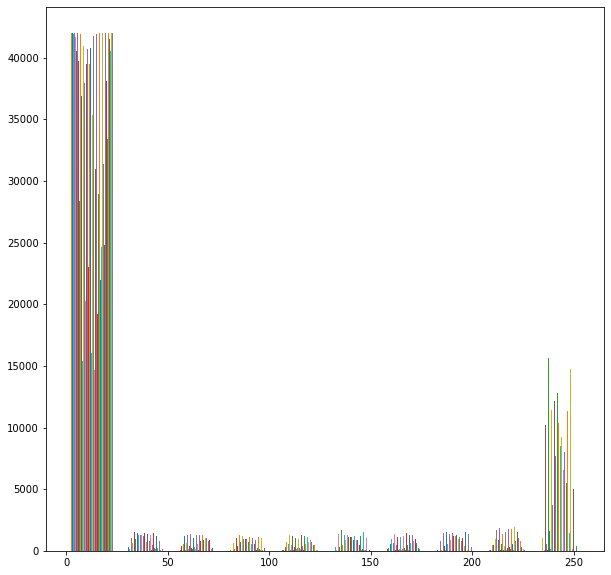

In [187]:
# Histogram of values of the pixels
plt.figure(figsize=(10,10))
plt.hist(traindfpix)
plt.show()

In [188]:
# Converting values to binary as most of the values are around 0 and 250
# Chosing a value for seperating the pixel value to Black or White.
sep = [0,25,50,75,100,125,150,175,200,225,250]
bindict = {}

for x in sep:
    bindict[x] = (traindfpix.copy())

for m in sep:
    bindict[m][bindict[m]<=m] = 0
    bindict[m][bindict[m]>m] = 1

# Preview of Figures for different value of seperator. 

# for m in sep:
#     fig, axes = plt.subplots(4, 4, figsize=(3,3),
#     subplot_kw={'xticks':[], 'yticks':[]},
#     gridspec_kw=dict(hspace=0.01, wspace=0.01))
#     fig.patch.set_facecolor("#FFFFFF")
#     fig.suptitle("sep = {}".format(m))
#     for i, ax in enumerate(axes.flat):
#         if i < 16:
#             ax.imshow(bindict[m].iloc[i].array.reshape((28,28)),cmap="binary")
#     plt.savefig("bin{}.png".format(m))
# plt.clf()

### Support Vector Machine
Accurcy of SVM will be used for chosing the value of the seperator for binary image.

In [189]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(bindict[25], traindf["label"] , test_size = 0.3, random_state = 200) 

In [190]:
# Function for generating accurcy score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def performance(true, pred, avg = "macro"):
    return [accuracy_score(true, pred),precision_score(true, pred, average = avg), recall_score(true, pred, average = avg), f1_score(true, pred, average = avg)]

def perdf(per, clf = 0):
    return pd.DataFrame({"accuracy_score:" : "{:.2%}".format(per[0]) ,"precision_score:" :"{:.2%}".format(per[1]), "recall_score:" : "{:.2%}".format(per[2]), "f1_score:" : "{:.2%}".format(per[3])},index=[clf])

In [191]:
# Linear SVM
from sklearn.svm import SVC

linearsvc = SVC(kernel = 'linear')
linearsvc.fit(x_train,y_train)
perdf(performance(y_test,linearsvc.predict(x_test)),"Linear SVM")


,accuracy_score:,precision_score:,recall_score:,f1_score:
Linear SVM,91.41%,91.37%,91.31%,91.32%


In [192]:
# SVM in RBF Kernel with default parameters.
defaultsvc = SVC()
defaultsvc.fit(x_train,y_train)
perdf(performance(y_test,defaultsvc.predict(x_test)),"default SVM")

,accuracy_score:,precision_score:,recall_score:,f1_score:
default SVM,97.12%,97.11%,97.10%,97.10%


In [193]:
# Accurcies for different seperators with default SVM
sc = []
for m in sep:
    x_train, x_test, y_train, y_test = train_test_split(bindict[m], traindf["label"] , test_size = 0.3, random_state = 200) 
    defaultsvc = SVC()
    defaultsvc.fit(x_train,y_train)
    sc.append((m,defaultsvc.score(x_test,y_test)))

The best value of the seperator is 25 with 97.12% accurcy


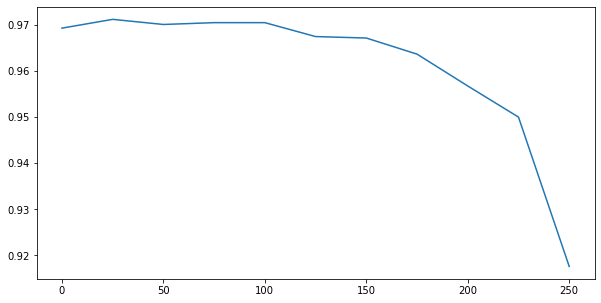

In [194]:
# Graph of the accurcy by the value of the seperator
sc.sort(key= lambda x: x[1],reverse=True)
print("The best value of the seperator is {} with {:.2%} accurcy".format(sc[0][0],sc[0][1]))
sc.sort(key= lambda x: x[0],reverse=True)
x = list(list(zip(*sc))[0])
y = list(list(zip(*sc))[1])
plt.figure(figsize=(10,5))   
plt.plot(x,y)
plt.show()

### Dimension Reduction with PCA

In [195]:
# Chosing the percentage of variance kept after PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

ss = StandardScaler()
scaleddata = ss.fit_transform(bindict[25])
acck = []

for n in [.1,.2,.3,.4,.5,.55,.6,.65,.70,.75,.80,.85,.90,.95,None]: #
    acc = []
    pca = PCA(n_components=n)
    pcadata = pca.fit_transform(scaleddata)
    x_train, x_test, y_train, y_test = train_test_split(pcadata, traindf["label"] , test_size = 0.3, random_state = 200) 
    defaultsvc = SVC()
    defaultsvc.fit(x_train,y_train)
    acc.append(defaultsvc.score(x_test,y_test))
    if n == None:
        n = 1
    acck.append([n,np.mean(acc)])

The percentage of variance with the highest accurcy is 65% with 96.51% accuracy


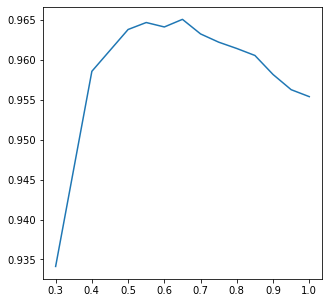

In [196]:
# Graph of accuracy by the percentage of variance
acck.sort(key = lambda x : x[0])
m = max(acck, key = lambda x: x[1])
print("The percentage of variance with the highest accurcy is {:.0%} with {:.2%} accuracy".format(m[0],m[1]))
plt.figure(figsize=(5,5))   
x = list(list(zip(*acck[2:]))[0])
h = list(list(zip(*acck[2:]))[1])
plt.plot(x,h)
plt.show()

In [197]:
# Tranform the grey scale data to binary B&W data by tranforming pixel with value higher than 25 to Black and others to White.
# Reducing the dimention of Binary Data by using PCA with 80% of variance.

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

ss = StandardScaler()
scaleddata = ss.fit_transform(bindict[25])
pca = PCA(n_components=0.80).fit(scaleddata)
pcadata = pca.transform(scaleddata)

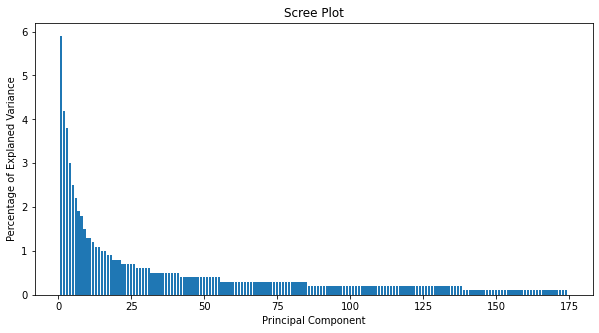

In [198]:
# Scree Plot
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals = 1)
labels = ['PC'+str(x) for x in range(1,len(per_var)+1)]
pca_df = pd.DataFrame(pcadata, columns=labels)
plt.figure(figsize=(10,5))    
plt.bar(x = range(1, len(per_var) + 1), height = per_var)
plt.ylabel("Percentage of Explaned Variance")
plt.xlabel("Principal Component")
plt.title("Scree Plot")
plt.show()

Text(0, 0.5, 'PC2 - 4.2%')

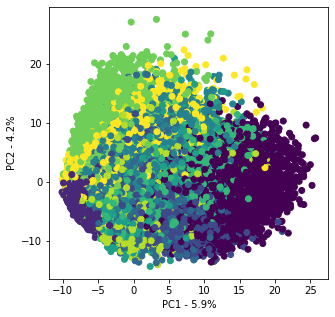

In [199]:
# Scatter plot of data on first 2 Principal Component
plt.figure(figsize=(5,5))    
plt.scatter(pca_df.PC1, pca_df.PC2,c=traindf["label"])
plt.xlabel("PC1 - {0}%".format(per_var[0]))
plt.ylabel("PC2 - {0}%".format(per_var[1]))

In [200]:
# Choosing parameters for SVM
from sklearn.model_selection import KFold

# # 5-Fold Cross Validation for finding parameters
# x_train, x_test, y_train, y_test = train_test_split(pca_df, traindf["label"] , test_size = 0.3, random_state = 200) 

# ack = []
# for c in [1,2,5,10,15,20,25,30,35,40,45,50]:
#     for ga in ["scale",0.0001,0.0005,0.001,0.0075,0.01,0.0125,0.015,0.05,0.1,0.5,1,2,5,10]:
#         svm=SVC(C = c, gamma = ga, random_state = 42)
#         kf = KFold(5)
#         acc = []
#         for train_ind , test_ind in kf.split(x_train):
#             svm.fit(x_train.iloc[train_ind],y_train.iloc[train_ind])
#             acc.append(svm.score(x_train.iloc[test_ind],y_train.iloc[test_ind]))
#         ack.append([c,ga,np.mean(acc)])

# ackdf = pd.DataFrame(data=ack,columns=["c","gamma","score"])
# ackdf.to_csv("ack.csv")

# Code for Hyperparameter Tuning are skipped to minimize runtime.
ackdf = pd.read_csv(pwd + "/ack.csv")

The parameter with best accurcy is c = 20.0, gamma = 0.001 with accuracy 96.878%


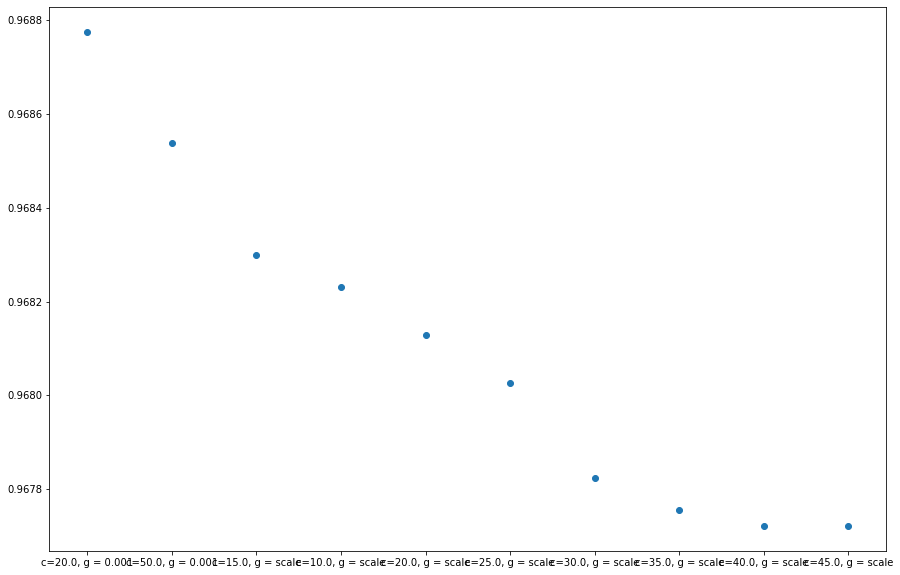

In [201]:
# Parameters with top 10 accurcies
lab = []
sc = []
temp = ackdf.sort_values(by=["score"], ascending= False, ignore_index = True).head(10)
for n in range(10):
    lab.append("c={}, g = {}".format(temp.iat[n,0], temp.iat[n,1]))
    sc.append(temp.iat[n,2])

print("The parameter with best accurcy is c = {}, gamma = {} with accuracy {:.3%}".format(temp.iat[0,0],temp.iat[0,1],temp.iat[0,2]))
plt.figure(figsize=(15,10))  
plt.scatter(lab,sc)
plt.show()

In [202]:
# Train score and test score for top 5 pairs of prameters.

x_train, x_test, y_train, y_test = train_test_split(pca_df, traindf["label"] , test_size = 0.3, random_state = 200) 
tsts = []

for c, ga in [(20, 0.001),(50,0.001),(15,"scale"),(10,"scale"),(20,"scale")]:
    svm=SVC(C = c, gamma = ga, random_state = 200)
    svm.fit(x_train,y_train)
    tsts.append([(c,ga),svm.score(x_train, y_train),svm.score(x_test, y_test)])

tsts.sort(key = lambda x: x[2],reverse=True)
tstsdf = pd.DataFrame(tsts, columns = ["Parameter","Train Score","Test Score"])
tstsdf


,Parameter,Train Score,Test Score
0,"(20, 0.001)",0.997007,0.968254
1,"(50, 0.001)",0.999218,0.967460
2,"(10, scale)",0.998027,0.966905
3,"(20, scale)",0.999388,0.966905
4,"(15, scale)",0.999014,0.966825


In [210]:
# Importing test data and tranforming data by PCA
testdf = pd.read_csv(pwd + "/test.csv")
ss = StandardScaler()
scaleddata = ss.fit_transform(testdf)
pcatestdata = pca.transform(scaleddata)
pcatest_df = pd.DataFrame(pcatestdata,  columns=labels)

# Creating model with all training data.
svm=SVC(C = 20, gamma = 0.001, random_state = 200)
svm.fit(pca_df,traindf["label"])

# Prediction of the test data
result = svm.predict(pcatest_df)


In [213]:
# Exporting the result
submit = pd.DataFrame({'ImageId' : range(1,len(result)+1), 'Label' : result})
submit.to_csv('result.csv', index = False)
